In [3]:
# find out how many states are in main data,
# use of aic, bic ect

In [1]:
import sys
import numpy as np

sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/final/tests/selecting_amount_of_states_hmm', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
import pickle
from importlib import reload
import numpy as np

In [3]:
# Load state sequence and data from the pickle file
with open('/Users/david/Documents/mastersCode/ubm/final/tests/train-test-val.pkl', 'rb') as file:
    loaded_train_test_val = pickle.load(file)

# Access the loaded data
# loaded_ss = loaded_data['state_sequence']
# loaded_data = loaded_data['data']

In [4]:
from final.useful import *

In [5]:
nfft = 128 # 32
labels = np.unique(loaded_train_test_val['train'].sample_labels)
# get_log_power_feature()

In [14]:
train_labels = loaded_train_test_val['train'].sample_labels
train_samples = loaded_train_test_val['train'].samples
# humpback_indices = train_labels == 0
# train_samples_humpback = [item for item, condition in zip(train_samples, humpback_indices) if condition]

val_labels = loaded_train_test_val['val'].sample_labels
val_samples = loaded_train_test_val['val'].samples
# humpback_indices_val = val_labels == 0
# val_samples_humpback = [item for item, condition in zip(val_samples, humpback_indices_val) if condition]

In [15]:
def get_feature(sample, nfft):
    feat = np.log(np.square(np.abs(librosa.stft(sample, n_fft=nfft)).T))
    return feat

In [16]:
train_features = []
val_features = []
for sample in train_samples:
    train_features.append(get_feature(sample, nfft))

for sample in val_samples:
    val_features.append(get_feature(sample, nfft))


In [31]:
from sklearn.utils import check_random_state
rs = check_random_state(546)
label = 0
indices = np.array(train_labels == label)
selected_train_features = [features for features, select in zip(train_features, indices) if select]
indices = np.array(val_labels == label)
selected_val_features = [features for features, select in zip(val_features, indices) if select]

# with open('aic_states_humpback.pickle', 'wb') as file:
#     pickle.dump(selected_train_features, file)


In [18]:
def calculate_aic_bic(model, features):
    log_likelihood = model.score(features)
    n_params = model.n_features * model.n_components + (model.n_components - 1) * model.n_components
    n_samples = len(features)

    aic = -2 * log_likelihood + 2 * n_params
    bic = -2 * log_likelihood + n_params * np.log(n_samples)

    return aic, bic

In [19]:

aic = []
bic = []
lls = []
ns = np.arange(2,25)
label = 0 # humpback

In [ ]:

for n in ns:
    print('training models for: ', n)
    best_ll = None
    best_model = None
    for i in range(10):
        h = GaussianHMM(n, n_iter=200, tol=1e-4, random_state=rs)
        h.fit(np.concatenate(selected_train_features))
        score = h.score(np.concatenate(selected_val_features))
        if not best_ll or best_ll < best_ll:
            best_ll = score
            best_model = h
    aic_n, bic_n = calculate_aic_bic(best_model, np.concatenate(selected_val_features))
    aic.append(aic_n)
    bic.append(bic_n)
    lls.append(best_model.score(np.concatenate(selected_val_features)))
    print('completed models for: ', n)


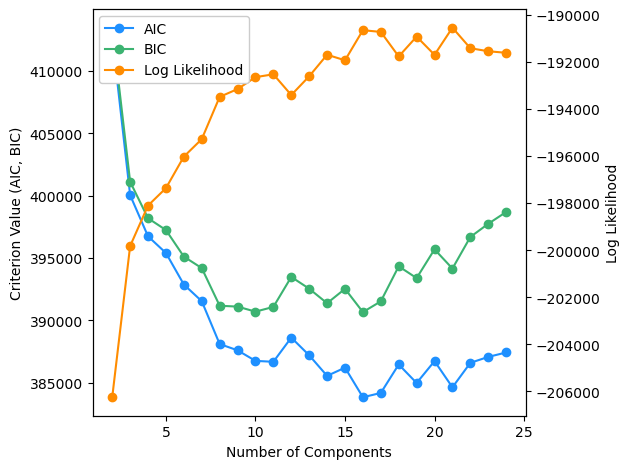

In [29]:

fig, ax = plt.subplots()
# Plot AIC and BIC on the left y-axis
ln1 = ax.plot(ns, aic, label="AIC", color="dodgerblue", marker="o")
ln2 = ax.plot(ns, bic, label="BIC", color="mediumseagreen", marker="o")

# Create a twin y-axis for Log Likelihood
ax2 = ax.twinx()
ln3 = ax2.plot(ns, lls, label="Log Likelihood", color="darkorange", marker="o")

# Combine legend from both axes
lines = ln1 + ln2 + ln3
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, facecolor='white',loc="upper left", framealpha=1).set_zorder(100)

# Set labels and title
ax.set_ylabel("Criterion Value (AIC, BIC)")
ax2.set_ylabel("Log Likelihood")
ax.set_xlabel("Number of Components")

# Move legend to the right side of the last axis
all_axes = fig.get_axes()
for axis in all_axes:
    legend = axis.get_legend()
    if legend is not None:
        legend.remove()
        all_axes[-1].add_artist(legend)

# Adjust layout
fig.tight_layout()
plt.savefig('humpback_whale_aic.png', bbox_inches='tight')
plt.show()
